In [29]:
import pandas as pd
import numpy as np
import PIL.Image
import tensorflow as tf
import matplotlib.pyplot as plt

training_dir = './Archive/train/'
validation_dir = './Archive/val/'
test_dir = './Archive/test/'


batch_size = 30
img_height = 160
img_width = 160 

train_ds = tf.keras.utils.image_dataset_from_directory(
    training_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory( 
    test_dir, 
    image_size=(img_height, img_width),
    batch_size=batch_size)
class_names = train_ds.class_names
print(class_names)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
['NORMAL', 'PNEUMONIA']


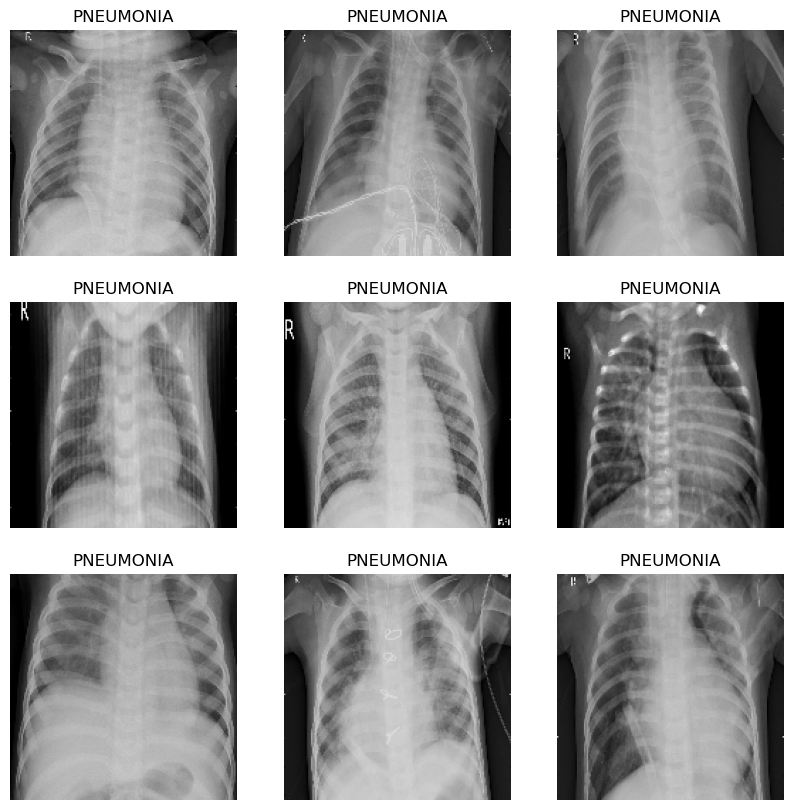

In [30]:
plt.figure(figsize=(10, 10))  
for images, labels in train_ds.take(1):  
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)  
    plt.imshow(images[i].numpy().astype("uint8"))  
    plt.title(class_names[labels[i]])  
    plt.axis("off") 

In [31]:
for image_batch, labels_batch in train_ds:
    print(f'Size of single image batch: {image_batch.shape}')
    print(f'Size of labels batch: {labels_batch.shape}')
    break

Size of single image batch: (30, 160, 160, 3)
Size of labels batch: (30,)


In [32]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [33]:
model = tf.keras.Sequential([
  normalization_layer,
  tf.keras.layers.Conv2D(10, (3, 3), activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(2),
  tf.keras.layers.Conv2D(20, (3, 3), activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(2),
  tf.keras.layers.Conv2D(40, (3, 3), activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(2),
  tf.keras.layers.Conv2D(80, (3, 3), activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(2),
  tf.keras.layers.Conv2D(160, (3, 3), activation='relu', padding='same'),
  tf.keras.layers.AveragePooling2D(2),
  tf.keras.layers.Conv2D(160, (3, 3), activation='relu', padding='same'),
  tf.keras.layers.AveragePooling2D(4),
  tf.keras.layers.Conv2D(160, (3, 3), activation='relu', padding='same'),
  tf.keras.layers.AveragePooling2D(1),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(8, activation='relu'),
  tf.keras.layers.Dense(2, activation='softmax'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

In [34]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
  metrics=['accuracy'])

history = model.fit(
  train_ds,
  validation_data= validation_ds,
  epochs=8
)

Epoch 1/8


/Users/nayem/anaconda3/lib/python3.11/site-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


174/174 [==============================] - 23s 129ms/step - loss: 0.6713 - accuracy: 0.6158 - val_loss: 0.7106 - val_accuracy: 0.5000
Epoch 2/8
174/174 [==============================] - 19s 108ms/step - loss: 0.5808 - accuracy: 0.7669 - val_loss: 0.6147 - val_accuracy: 0.7500
Epoch 3/8
174/174 [==============================] - 18s 105ms/step - loss: 0.5024 - accuracy: 0.8462 - val_loss: 0.5991 - val_accuracy: 0.6875
Epoch 4/8
174/174 [==============================] - 18s 104ms/step - loss: 0.4448 - accuracy: 0.8750 - val_loss: 0.5362 - val_accuracy: 0.8125
Epoch 5/8
174/174 [==============================] - 18s 102ms/step - loss: 0.4106 - accuracy: 0.8806 - val_loss: 0.6934 - val_accuracy: 0.6875
Epoch 6/8
174/174 [==============================] - 18s 102ms/step - loss: 0.3745 - accuracy: 0.8932 - val_loss: 0.6124 - val_accuracy: 0.7500
Epoch 7/8
174/174 [==============================] - 18s 102ms/step - loss: 0.3456 - accuracy: 0.9026 - val_loss: 0.5506 - val_accuracy: 0.7500
Ep

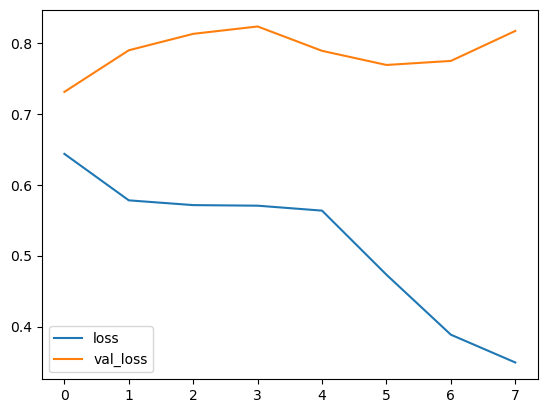

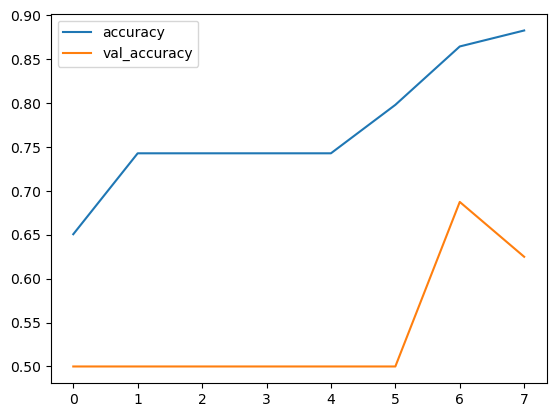

Final training accuracy: 88.28604221343994
Final validation accuracy: 62.5


In [23]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
plt.show()

# Print final training accuracy
print("Final training accuracy: {}".format(history.history['accuracy'][-1]*100 ))

# Print final validation accuracy
print("Final validation accuracy: {}".format(history.history['val_accuracy'][-1] *100 ))

In [24]:
loss, accuracy = model.evaluate(test_ds)
print('The accuracy of the model on test dataset is',
      np.round(accuracy*100))

20/20 [==============================] - 1s 52ms/step - loss: 0.5382 - accuracy: 0.7901
The accuracy of the model on test dataset is 79.0


1/1 [==============================] - 0s 14ms/step
[0.38659933]
Normal


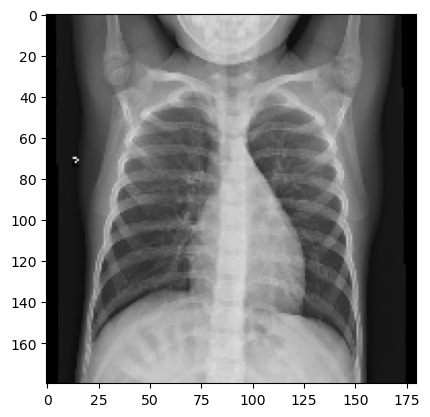

In [27]:
test_image = tf.keras.utils.load_img(
    './Archive/test/NORMAL/NORMAL2-IM-0060-0001.jpeg',
    target_size=(img_height, img_width))

plt.imshow(test_image)
 
test_image = tf.keras.utils.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
 
result = model.predict(test_image)
 
class_probabilities = result[0]
 
# Determine the class with the highest probability and print its label
print(class_probabilities)
if class_probabilities[0] <= 0.5:
    print("Normal")
else:
    print("Pneumonia")

1/1 [==============================] - 0s 17ms/step
[0.8749036]
Pneumonia


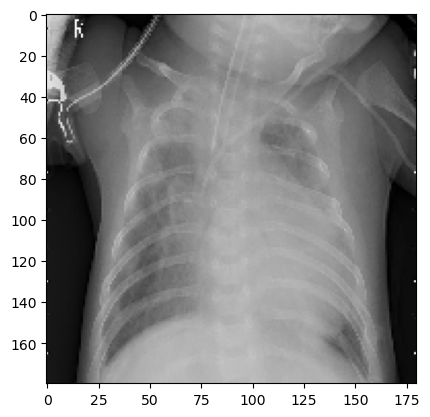

In [28]:
test_image = tf.keras.utils.load_img(
    './Archive/test/PNEUMONIA/person1_virus_6.jpeg',
    target_size=(img_height, img_width))

plt.imshow(test_image)
 
test_image = tf.keras.utils.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
 
result = model.predict(test_image)
 
class_probabilities = result[0]
 
# Determine the class with the highest probability and print its label
print(class_probabilities)
if class_probabilities[0] <= 0.5:
    print("Normal")
else:
    print("Pneumonia")